### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from scipy.special import gamma
from scipy.stats import moment, kurtosis, entropy

from collections import defaultdict

from itertools import product, combinations

import pickle
from joblib import Parallel, delayed

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
ROOT_PATH = '/Users/nastya/dev/time_series_prediction/'

### Wishart

In [3]:
class Wishart:
    def __init__(self, wishart_neighbors, significance_level):
        self.wishart_neighbors = wishart_neighbors  # Number of neighbors
        self.significance_level = significance_level  # Significance level

    def fit(self, X):
        from sklearn.neighbors import KDTree
        kdt = KDTree(X, metric='euclidean')

        #add one because you are your neighb.
        distances, neighbors = kdt.query(X, k = self.wishart_neighbors + 1, return_distance = True)
        neighbors = neighbors[:, 1:]


        distances = distances[:, -1]
        indexes = np.argsort(distances)
        
        size, dim = X.shape

        self.object_labels = np.zeros(size, dtype = int) - 1

        #index in tuple
        #min_dist, max_dist, flag_to_significant
        self.clusters = np.array([(1., 1., 0)])
        self.clusters_to_objects = defaultdict(list)
        # print('Start clustering')

        for index in indexes:
            neighbors_clusters =\
                np.concatenate([self.object_labels[neighbors[index]], self.object_labels[neighbors[index]]])
            unique_clusters = np.unique(neighbors_clusters).astype(int)
            unique_clusters = unique_clusters[unique_clusters != -1]


            if len(unique_clusters) == 0:
                self._create_new_cluster(index, distances[index])
            else:
                max_cluster = unique_clusters[-1]
                min_cluster = unique_clusters[0]
                if max_cluster == min_cluster:
                    if self.clusters[max_cluster][-1] < 0.5:
                        self._add_elem_to_exist_cluster(index, distances[index], max_cluster)
                    else:
                        self._add_elem_to_noise(index)
                else:
                    my_clusters = self.clusters[unique_clusters]
                    flags = my_clusters[:, -1]
                    if np.min(flags) > 0.5:
                        self._add_elem_to_noise(index)
                    else:
                        significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)
                        significan *= self.wishart_neighbors
                        significan /= size
                        significan /= np.power(np.pi, dim / 2)
                        significan *= gamma(dim / 2 + 1)
                        significan_index = significan >= self.significance_level

                        significan_clusters = unique_clusters[significan_index]
                        not_significan_clusters = unique_clusters[~significan_index]
                        significan_clusters_count = len(significan_clusters)
                        if significan_clusters_count > 1 or min_cluster == 0:
                            self._add_elem_to_noise(index)
                            self.clusters[significan_clusters, -1] = 1
                            for not_sig_cluster in not_significan_clusters:
                                if not_sig_cluster == 0:
                                    continue

                                for bad_index in self.clusters_to_objects[not_sig_cluster]:
                                    self._add_elem_to_noise(bad_index)
                                self.clusters_to_objects[not_sig_cluster].clear()
                        else:
                            for cur_cluster in unique_clusters:
                                if cur_cluster == min_cluster:
                                    continue

                                for bad_index in self.clusters_to_objects[cur_cluster]:
                                    self._add_elem_to_exist_cluster(bad_index, distances[bad_index], min_cluster)
                                self.clusters_to_objects[cur_cluster].clear()

                            self._add_elem_to_exist_cluster(index, distances[index], min_cluster)

        return self.clean_data()

    def clean_data(self):
        unique = np.unique(self.object_labels)
        index = np.argsort(unique)
        if unique[0] != 0:
            index += 1
        true_cluster = {unq :  index for unq, index in zip(unique, index)}
        result = np.zeros(len(self.object_labels), dtype = int)
        for index, unq in enumerate(self.object_labels):
            result[index] = true_cluster[unq]
        return result

    def _add_elem_to_noise(self, index):
        self.object_labels[index] = 0
        self.clusters_to_objects[0].append(index)

    def _create_new_cluster(self, index, dist):
        self.object_labels[index] = len(self.clusters)
        self.clusters_to_objects[len(self.clusters)].append(index)
        self.clusters = np.append(self.clusters, [(dist, dist, 0)], axis = 0)

    def _add_elem_to_exist_cluster(self, index, dist, cluster_label):
        self.object_labels[index] = cluster_label
        self.clusters_to_objects[cluster_label].append(index)
        self.clusters[cluster_label][0] = min(self.clusters[cluster_label][0], dist)
        self.clusters[cluster_label][1] = max(self.clusters[cluster_label][1], dist)

### Lorenz time series generator

In [4]:
n_train = 10_000
n_test = 1_000 + 300 # to get test set of 1000, 300 - про запас
n_passed = 3_000
n_valid = 2_000

with open(ROOT_PATH + 'data/lorenz.dat', 'rb') as f:
    Y = pickle.load(f)

Y1 = np.array(Y[n_passed:n_passed + n_train]).reshape(-1)
Y2 = np.array(Y[n_passed + n_train:n_passed + n_train + n_test]).reshape(-1)
Y3 = np.array(Y[n_passed + n_train + n_test:n_passed + n_train + n_test + n_valid]).reshape(-1)

### Algorithm

In [10]:
class TimeSeriesPredictor:
    '''Class for time series prediction 
    Pipeline:
    New class object 
        -> cluster_motifs with training set or set from saved motifs 
        -> prediction with different parameters
    Clustering of motifs is done once for each class object

    Attributes
    ---------
    used_patterns: np.ndarray of shape (n_patterns, 3)
        Patterns used for prediction
    clustered_motifs: list of length (n_patterns) of np.array of shape (n_clusters, pattern_length)
        List of cluster centers for each pattern, indices correspond with used_patterns indices

    '''

    def __init__(self):
        self.clustered_motifs = None     
        self.non_pred_model = None
        self.k_max = 0
        self.pattern_length = 0  


    def __init__(self, clustered_motifs, non_pred_model, k_max=10, pattern_length=3):
        self.clustered_motifs = clustered_motifs     
        self.non_pred_model = non_pred_model
        self.k_max = k_max
        self.pattern_length = pattern_length


    def cluster_motifs(self, Y1, beta=0.1, mc_method='db', \
        k_max=10, pattern_length=3, **kwargs):
        '''Cluster motifs by patterns, result saved in class attributes and returned from function
        pattern_length = 4
        n_patterns = beta * k_max^pattern_length

        Parameters
        ----------
        Y1: list or 1d np.ndarray
            Training time series data
        beta: float from 0 to 1, default=0.1
            Percentage of used patterns
        mc_method: {'wi', 'db'}, default='db'
            Clustering method for motifs; 'wi' - Wishart, 'db' - DBSCAN
        k_max: int, default=10
            Max distance between points in pattern
        pattern_length: int, default=3
            Length of patterns
        
        **kwargs: dict
        eps: float from 0 to 1, default=0.01
            Max distance within one cluster for DBSCAN and Wishart clustering 
        min_samples: int > 1 or float from 0 to 1, default=5
            Min number of samples in cluster for DBSCAN and Wishart clustering 

        Returns
        ----------
        clustered_motifs: list of size (n_patterns)
            List of tuples of clustered motifs: [(pattern, clusters)]
            clusters: list of length (n_patterns) of np.array of shape 
                (n_clusters, pattern_length + 1)
        '''
        clustered_motifs = []

        # patterns = np.array([[i1, i2, i3] 
        #             for i1 in range(1, k_max + 1)
        #             for i2 in range(1, k_max + 1)
        #             for i3 in range(1, k_max + 1)])

        self.k_max = k_max
        self.pattern_length = pattern_length
        patterns = list(product(range(1, k_max + 1), repeat=pattern_length))
        patterns = np.array([list(p) for p in patterns])
        
        used_patterns = patterns[np.random.choice(patterns.shape[0], \
            size=int(beta * patterns.shape[0]))]

        eps = kwargs.get('eps', 0.01)
        min_samples = kwargs.get('min_samples', 5)

        for pattern in used_patterns:
            motifs = []

            # make dataset for classification
            X_cl_idx = len(Y1) - 1 - np.cumsum(pattern[::-1])
            X_cl_idx = X_cl_idx[::-1]
            X_cl_idx = np.append(X_cl_idx, len(Y1) - 1)
            x = [X_cl_idx - i for i in range(len(Y1) - np.sum(pattern))]
            
            X_cl = np.array([np.take(Y1, X_cl_idx - i) for i in range(len(Y1) - np.sum(pattern))])
            X_cl = X_cl.astype(float)

            if mc_method == 'db':
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                cl_labels = dbscan.fit_predict(X_cl)
            elif mc_method == 'wi':
                wishart = Wishart(min_samples, eps)
                cl_labels = wishart.fit(X_cl)
                cl_labels = cl_labels - 1
            
            n_clusters = len(np.unique(cl_labels))
            if np.isin(cl_labels, -1).any():
                n_clusters -= 1
            if n_clusters == 0:
                motifs = []
            else:
                motifs = np.array([np.mean(X_cl[cl_labels  == i], axis=0) for i in range(n_clusters)])
            clustered_motifs.append(motifs)
        
        self.clustered_motifs = list(zip(used_patterns, clustered_motifs))

        return self.clustered_motifs
              
                
    def set_motifs(self, clustered_motifs, k_max=10, pattern_length=3):
        '''Set used patterns and motifs, usually loaded from earlier saved

        Parameters
        ----------
        clustered_motifs: list of size (n_patterns)
            List of tuples of clustered motifs: [(pattern, clusters)]
            clusters: list of length (n_patterns) of np.array of shape 
                (n_clusters, pattern_length + 1)
        k_max: int, default=10
            Max distance between points in pattern
        pattern_length: int, default=3
            Length of patterns
        '''
        self.clustered_motifs = clustered_motifs
        self.k_max = k_max
        self.pattern_length = pattern_length
    

    def set_non_pred_model(self, non_pred_model):
        self.non_pred_model = non_pred_model


    def predict(self, Y_preceding, h, up_method, \
        alg_type, match_thershold=0.01, **kwargs):
        '''Predict h next values of time series

        Parameters
        ----------
        Y_preceding: list or 1D np.array
            Time series segment preceding the segment to predict. 
            Size has to be at least k_max*pattern_length (30 for default parameters)
        h: int
            Prediciton horizon
        up_method: str from {'a', 'wi', 'db', 'op'}
            Method of estimating unified prediction
        alg_type: str from {'s', 'tp'}
            's' - one-step predicition, no trajectories, p = 1
            'tp' - trajectories with random perturbation, p > 1
        match_thershold: float, default=0.01
            Threshold for motif to match

        **kwargs
        n_trajectories: int, default=20
            Number of trajectories in case alg_type='tp'
        Y3: list or 1D np.ndarray
            Validation set

        Returns:
            np.array: predicted values in case 's' and 'tp'
            np.array: predicted trajectories in case 'tp'
        '''
        
        if alg_type == 's':
            Y_pred = np.array([], dtype=object)
            possible_predictions_list = []
            for i in range(h):
                possible_predictions, distances = self.predict_one_step(Y_preceding, \
                    Y_pred, match_thershold)

                is_predictable = self.non_pred_model.is_predictable(possible_predictions)
                if is_predictable:
                    kwargs['distances'] = distances
                    unified_prediction = self.unified_prediction(possible_predictions, \
                        up_method, **kwargs)
                else:
                    unified_prediction = 'N'
                
                Y_pred = np.append(Y_pred, unified_prediction)
                possible_predictions_list.append(possible_predictions)
            
            if hasattr(self.non_pred_model, 'is_predictable_by_up'):
                is_pred = self.non_pred_model.is_predictable_by_up(Y_pred)
                for i in range(h):
                    if not is_pred[i]:
                        Y_pred[i] = 'N'

            self.non_pred_model.reset()
            return Y_pred, possible_predictions_list

        if alg_type == 'tp':
            n_trajectories = kwargs.get('n_trajectories', 20)
            trajectories = []
            for i in range(n_trajectories):
                Y_pred = np.array([])
                for i in range(h):
                    possible_predictions, distances = self.predict_one_step(Y_preceding, \
                        Y_pred, match_thershold)

                    is_predictable = self.non_pred_model.is_predictable(possible_predictions)
                    if is_predictable:
                        kwargs['distances'] = distances
                        kwargs['random_perturbation'] = True
                        unified_prediction = self.unified_prediction(possible_predictions, \
                            up_method, **kwargs)
                    else:
                        unified_prediction = 'N'
                    
                    Y_pred = np.append(Y_pred, unified_prediction)
                trajectories.append(Y_pred)
            
            trajectories = np.array(trajectories)
            Y_pred = np.array([])
            possible_predictions_list = []
            for i in range(h):
                possible_predictions = trajectories[:, i]
                possible_predictions = possible_predictions[possible_predictions != 'N']
                possible_predictions = possible_predictions.astype(float)
                possible_predictions_list.append(possible_predictions)
                # unified_prediction = self.unified_prediction(possible_predictions, up_method, **kwargs)
                unified_prediction = np.mean(possible_predictions)
                Y_pred = np.append(Y_pred, unified_prediction)
            return Y_pred, possible_predictions_list, trajectories

    
    def predict_one_step(self, Y_preceding, Y_pred, match_thershold=0.01):
        '''One step prediction of time series

        Parameters
        ----------
        Y_preceding: list or 1D np.array
            Time series segment preceding the segment to predict. 
            Size has to be at least k_max*pattern_length (30 for default parameters)
        Y_pred: list or 1D np.ndarray
            Already predicted values from previous steps of algorithm
        match_thershold: float, default=0.01
            Threshold for motif to match

        Returns
        ----------
        possible_predictions: np.ndarray
            List of possible predictions for the point
        distances: np.ndarray
            List of distances of possible prediction to cluster center, 
            used for some algorithms of calculating unified prediction
        '''
        Y_all = np.append(Y_preceding, Y_pred)
        possible_predictions = np.array([])
        distances = np.array([])
        
        for i in range(len(self.clustered_motifs)):
            pattern = self.clustered_motifs[i][0]
            motifs = self.clustered_motifs[i][1]

            c_idx = np.full(self.pattern_length, len(Y_all))
            for j in range(self.pattern_length):
                c_idx[j] -= np.sum(pattern[j:])
            # print(pattern, c_idx, np.take(Y, c_idx, axis=0), Y[-30:])
            
            c = np.take(Y_all, c_idx, axis=0)
            if np.isin(c, 'N').any():
                continue
            c = c.astype(float)
            
            for motif in motifs:
                if np.linalg.norm(c - motif[:-1]) < match_thershold:
                    possible_predictions = np.append(possible_predictions, motif[-1])
                    distances = np.append(distances, np.linalg.norm(c - motif[:-1]))
        return possible_predictions, distances
   

    def unified_prediction(self, possible_predictions, up_method, \
        random_perturbation=False, **kwargs):
        '''Calculates unified prediciton from set of possible predicted values

        Parameters
        ----------
        possible_predictions: list or 1D np.array
            List of possible predictions
        up_method: str from {'a', 'wi', 'db', 'op'}
            Method of estimating unified prediciton
            'a'  - average
            'wi' - clustering with Wishart, get largest cluster mean
            'db' - clustering with DBSCAN, get largest cluster mean
            'op' - clustering with OPTICS, get largest cluster mean
        random_perturbation: boolean
            Add noise to unified prediction

        **kwargs
        -- for Wishart, DBSCAN and OPTICS clustering --
        min_samples: int > 1 or float between 0 and 1, default=5
            Minimal number of samples in cluster
        eps: float from 0 to 1, default=0.01
            Max distance within one cluster
        cluster_size_threshold: float from 0 to 1, default=0.2
            Minimal percentage of points in largest cluster to call point predictable
        one_cluster_rule: boolean, defalut=False
            Point is predictable only is there is one cluster (not including noise)
        '''

        if len(possible_predictions) == 0:
            return 'N'
        min_samples = kwargs.get('min_samples', 5)
        eps = kwargs.get('eps', 0.01)

        if up_method == 'a':
            avg = np.mean(possible_predictions)
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg

        if up_method == 'wi' or up_method == 'db' or up_method=='op':  
            try: 
                if up_method == 'db': 
                    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
                    
                elif up_method == 'wi':
                    clustering = Wishart(min_samples, eps)
                    labels = clustering.fit(np.array(possible_predictions).reshape(-1, 1))
                    labels[labels == 0] = -1
                elif up_method == 'op':
                    clustering = OPTICS(max_eps=eps, min_samples=min_samples)
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
            except:
                return 'N'
                
            threshold = kwargs.get('cluster_size_threshold', 0)
            one_cluster_rule = kwargs.get('one_cluster_rule', False)
            unique_labels, unique_counts = np.unique(labels, return_counts=True)
            unique_labels = zip(unique_labels, unique_counts)
            unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
            if len(unique_labels) == 0:
                return 'N'
            if one_cluster_rule and len(unique_labels) > 1:
                return 'N'
            x, y = map(list, zip(*unique_labels))
            max_count = max(y)
            if max_count / len(possible_predictions) < threshold:
                return 'N'

            max_cluster = list(filter(lambda x: x[1] == max_count, unique_labels))[0]
            
            avg = np.mean(possible_predictions[labels == max_cluster[0]])
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg


    def unified_prediction_weighted(self, possible_predictions, sep_indices, \
        up_method, weight_method='double_clustering', return_pp_without_noise=False, \
        **kwargs):
        
        if weight_method == 'double_clustering' or weight_method == 'weighted_average':
            ups = []
            for i in range(len(sep_indices) - 1):
                pp_iteration = possible_predictions[sep_indices[i]:sep_indices[i+1]]
                ups.append(self.unified_prediction(pp_iteration, up_method=up_method, \
                    random_perturbation=False, **kwargs))
            ups = np.array(ups, dtype=object)
            
            predictable = np.argwhere(ups != 'N').reshape(1, -1)[0]
            predictable_ups = np.take(ups, predictable).astype(float)
            eps_dist_clusters = 0.02
            if weight_method == 'double_clustering':
                if len(predictable_ups) == 0:
                    return 'N'
                if len(predictable_ups) <= 2:
                    return predictable_ups[0]
            
                if len(predictable_ups) > 2:
                    dbscan2 = DBSCAN(min_samples=2, eps=0.1)
                    labels2 = dbscan2.fit_predict(predictable_ups.reshape(-1, 1))
                    unique_labels, unique_counts = np.unique(labels2, return_counts=True)
                    unique_labels = zip(unique_labels, unique_counts)
                    unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
                    if len(unique_labels) == 0:
                        return predictable_ups[0]
                    x, y = map(list, zip(*unique_labels))
                    max_count = max(y)

                    max_cluster = list(filter(lambda x: x[1] == max_count, unique_labels))[0]
                    
                    avg = np.mean(predictable_ups[labels2 == max_cluster[0]])
                    return avg
            if weight_method == 'weighted_average':
                factor = 0.9
                weights = [factor ** x for x in range(len(sep_indices) - 1)]
                return np.average(predictable_ups, weights[:len(predictable_ups)])

        if weight_method in ['pattern_length_dist', 'factor', \
            'pattern_length', 'dist', 'dist_factor']:
            eps = kwargs.get('eps', 0.01)
            min_samples= kwargs.get('min_samples', 5)
            try: 
                if up_method == 'db': 
                    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
                elif up_method == 'wi':
                    clustering = Wishart(min_samples, eps)
                    labels = clustering.fit(np.array(possible_predictions).reshape(-1, 1))
                    labels = labels - 1
                elif up_method == 'op':
                    clustering = OPTICS(max_eps=eps, min_samples=min_samples)
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
            except:
                return 'N'
            
            unique_labels, counts = np.unique(labels, return_counts=True)
            factor = kwargs.get('factor', 0.9)
            if weight_method == 'factor':
                point_weights = []
                for i in range(len(sep_indices) - 1):
                    point_weights.extend([factor ** i] * (sep_indices[i + 1] - sep_indices[i]))
            elif weight_method == 'dist_factor':
                point_weights = kwargs.get('point_weights')
                for i in range(len(sep_indices) - 1):
                    for k in range(sep_indices[i], sep_indices[i + 1]):
                        point_weights[k] *= factor ** i
            else:
                point_weights = kwargs.get('point_weights')
                
            unique_labels = unique_labels if -1 not in unique_labels else unique_labels[1:]
            if len(unique_labels) == 0:
                return 'N'
            cluster_size = [0] * len(unique_labels)
            # print(point_weights)
            # print(sep_indices)
            for i in range(len(labels)):
                # print(len(cluster_size), labels[i])
                cluster_size[labels[i]] += point_weights[i]
            max_cluster = np.argmax(cluster_size)

            avg = np.mean(possible_predictions[labels == unique_labels[max_cluster]])

            if return_pp_without_noise:
                return avg, possible_predictions[labels != -1]
            return avg

        

    def self_healing_one_iteration(self, Y_preceding, unified_predictions, \
        possible_predictions, h, up_method='db', weighted=False, sep_indices=[], \
        fixed_points_idx=[], **kwargs):
        '''One iteration of self-healing 

        Parameters
        ----------
        Y_preceding: list or 1D np.array
            Time series segment preceding the segment to predict. 
            Size has to be at least k_max*pattern_length (30 for default parameters)
        unified_predictions: list or 1D np.ndarray of length h
            List of unified predictions from previous iteration or from base algorithm
        possible_predictions: list of h np.ndarrays
            List of lists of possible predictions for each point from previous uteration 
            or from base algorithm
        h: int
            Prediction horison
        up_method: str from {'a', 'wi', 'db', 'op'}
            See method unified_prediction

        **kwargs
        See method unified_prediction


        Returns
        ----------
        new_up: np.ndarray
            List of new unified predictions
        possible_predictions: list of np.ndarrays
            List of old and new possible predictions
        '''

        def take_ordered(indices, n_to_take):
            if n_to_take == 0:
                return [[]]
            return [list(c) for c in list(combinations(indices, n_to_take))]
            

        def get_all_matching_patterns(sliced):
            '''Get all patterns with not-N unified predictions

            Parameters
            ----------
            sliced: list or 1D np.ndarray
                List of unified predictions 30 before and 30 after (or to prediction horison) 
                predicted point

            Returns
            ----------
            matched_patterns: list
                List of tuples (j, index), where j is place of predicted point in pattern, 
                index is index of pattern in self.used_patterns
            '''
            used_patterns = [x[0] for x in self.clustered_motifs]
            matched_patterns = []
            current_point_index = self.k_max * self.pattern_length
            pred_left = np.argwhere(sliced[:current_point_index] != 'N').reshape(1, -1)[0]
            pred_right = np.argwhere(sliced[current_point_index + 1:] != 'N').reshape(1, -1)[0] + current_point_index + 1
            
            for left_n_of_points in range(self.pattern_length + 1):
                right_n_of_points = self.pattern_length - left_n_of_points
                take_left = take_ordered(pred_left.tolist(), left_n_of_points)
                
                for i in range(len(take_left)):
                    take_left[i].append(current_point_index)
                take_right = take_ordered(pred_right.tolist(), right_n_of_points)
                combos = [x[0] + x[1] for x in list(product(take_left, take_right))]
                dists = np.diff(combos)
                for dist in dists:
                    if np.all((dist > 0) & (dist <= self.k_max)):
                        index = -1
                        for i in range(len(used_patterns)):
                            if np.array_equal(used_patterns[i].tolist(), dist):
                                index = i
                                break
                        if index >= 0:
                            matched_patterns.append(tuple([left_n_of_points, index]))
            
            return matched_patterns


        Y_prec_with_up = np.append(Y_preceding, unified_predictions)
        healing_motif_match_eps = kwargs.get('healing_motif_match_eps', 0.01)
        pp_weights = kwargs.get('pp_weights')
        weight_method = kwargs.get('weight_method', None)
        for i in range(h):
            left = len(Y_preceding) + i - self.k_max * self.pattern_length
            right = len(Y_preceding) + i + self.k_max * self.pattern_length
            if right >= len(Y_prec_with_up):
                right = len(Y_prec_with_up) - 1
            curr_point_idx = self.k_max * self.pattern_length
            sliced = np.array(Y_prec_with_up[left:right + 1])

            indices_patterns_to_check = get_all_matching_patterns(sliced)
            for (j, index) in indices_patterns_to_check:
                pattern = self.clustered_motifs[index][0]
                motifs = self.clustered_motifs[index][1]

                c_idx = np.full(self.pattern_length + 1, curr_point_idx)
                c_idx[j] = curr_point_idx
                for k in range(j):
                    c_idx[k] -= np.sum(pattern[k:j])
                for k in range(j+1,self.pattern_length+1):
                    c_idx[k] += np.sum(pattern[j:k])
                
                try:
                    c = np.take(sliced, c_idx, axis=0)
                except:
                    continue
                c = np.delete(c, j, axis=0)
                if 'N' in c:
                    continue
                c = c.astype(float)
            
                for motif in motifs:
                    cut_motif = np.delete(motif, j)
                    if np.linalg.norm(c - cut_motif) < healing_motif_match_eps:
                        possible_predictions[i] = np.append(possible_predictions[i], \
                            motif[j])
                        if weight_method == 'pattern_length':
                            pp_weights[i].append(1 / sum(pattern))
                        if weight_method == 'pattern_length_dist':
                            pp_weights[i].append((1 / sum(pattern)) * (1 / np.linalg.norm(c - cut_motif)))
                        if weight_method == 'dist' or weight_method == 'dist_factor':
                            pp_weights[i].append(1 / np.linalg.norm(c - cut_motif))
                        
            if weighted:
                sep_indices[i].append(len(possible_predictions[i]))
        new_up = []
        for i in range(len(possible_predictions)):
            if self.non_pred_model.is_predictable(possible_predictions[i]) or \
                i in fixed_points_idx:

                if not weighted:
                    new_up.append(self.unified_prediction(possible_predictions[i], \
                        up_method=up_method, **kwargs))
                else:
                    if kwargs.get('clear_noise', False):
                        u, possible_predictions[i] = self.unified_prediction_weighted(\
                            possible_predictions[i], \
                            up_method=up_method, \
                            sep_indices=sep_indices[i], \
                            return_pp_without_noise=True, \
                            point_weights=pp_weights[i], \
                            **kwargs)
                        new_up.append(u)
                    else:
                        new_up.append(self.unified_prediction_weighted(\
                            possible_predictions[i], \
                            up_method=up_method, \
                            sep_indices=sep_indices[i], point_weights=pp_weights[i], \
                            **kwargs))
            else:
                new_up.append('N')
        
        if hasattr(self.non_pred_model, 'is_predictable_by_up'):
            is_pred = self.non_pred_model.is_predictable_by_up(new_up)
            for i in range(h):
                if not is_pred[i]:
                    new_up[i] = 'N'

        self.non_pred_model.reset()
        if not weighted:
            return np.array(new_up, dtype=object), possible_predictions
        else:
            return np.array(new_up, dtype=object), possible_predictions, sep_indices



    def self_healing(self, Y_preceding, h, return_n_iterations=False, \
        eps_stop=0.01, unified_predictions=None, \
        possible_predictions=None, healing_up_method='db', weighted_up=False,
        up_weights=None, fixed_points_idx=[], healing_logs_filepath=None, \
        **kwargs):
        '''Iterative algorithm of self-healing
        Criteria of stopping: 3 iterations no new unified predictions found AND 
            euclidian distance between two last iterations is less than eps_stop

        Parameters
        ----------
        Y_preceding: list or 1D np.array
            Time series segment preceding the segment to predict. 
            Size has to be at least k_max*pattern_length (30 for default parameters)
        h: int
            Prediction horison
        unified_predictions: list or 1D np.ndarray of length h, default=None
            List of unified predictions from base algorithm
            Can be None, then first iteration will be the same as base algorithm
        possible_predictions: list of h np.ndarrays
            List of lists of possible predictions for each point from base algorithm
            Can be None, then first iteration will be the same as base algorithm
        up_method: str from {'a', 'wi', 'db', 'op'}
            See method unified_prediction

        **kwargs
        See method unified_prediction

        Returns
        ----------
        unified_predictions: np.ndarray
            List of unified predictions after self-healing algorithm
        '''
        if unified_predictions is None:
            unified_predictions = np.full(h, 'N', dtype=object)
        if possible_predictions is None:
            possible_predictions = [[] for _ in range(h)]

        up_logs = []
        pp_logs = []
        non_pred_logs = []
        iteration = 0
        stop_criteria = False
        up_logs.append(unified_predictions.copy())
        pp_logs.append(possible_predictions.copy())
        non_pred_logs.append(np.count_nonzero(unified_predictions == 'N'))
        sep_indices = [[0] for _ in range(h)]
        used_patterns = [x[0] for x in self.clustered_motifs]
        pl = [sum(pattern) for pattern in used_patterns]
        avg_pattern_length = sum(pl) / len(pl)
        pp_weights = [[1 / avg_pattern_length] * len(possible_predictions[i]) for i in range(h)]
        kwargs['pp_weights'] = pp_weights

        while not stop_criteria:
            iteration += 1
            if not weighted_up:
                unified_predictions, possible_predictions = \
                    self.self_healing_one_iteration(Y_preceding, \
                    unified_predictions, possible_predictions, h, \
                    up_method=healing_up_method, fixed_points_idx=fixed_points_idx, \
                    **kwargs)
            else:
                unified_predictions, possible_predictions, sep_indices = \
                    self.self_healing_one_iteration(Y_preceding, \
                    unified_predictions, possible_predictions, h, up_method=healing_up_method, \
                        weighted=True, sep_indices=sep_indices, \
                        fixed_points_idx=fixed_points_idx, **kwargs)
            
            
            if hasattr(self.non_pred_model, 'is_predictable_by_up_log'):
                for i in range(h):
                    up_log = [l[i] for l in up_logs]
                    up_log.append(unified_predictions[i])
                    if not self.non_pred_model.is_predictable_by_up_log(up_log):
                        unified_predictions[i] = 'N'
                        

            up_logs.append(unified_predictions.copy())
            pp_logs.append(possible_predictions.copy())
            non_pred_logs.append(np.count_nonzero(unified_predictions == 'N'))

            
            if len(up_logs) > 2:
                np_1 = np.argwhere(up_logs[-1] != 'N').reshape(1, -1)[0]
                np_2 = np.argwhere(up_logs[-2] != 'N').reshape(1, -1)[0]
                np_3 = np.argwhere(up_logs[-3] != 'N').reshape(1, -1)[0]

                if np.array_equal(np_1, np_2) and np.array_equal(np_2, np_3):
                    pred_indices = np.argwhere(up_logs[-1] != 'N')
                    predicted_1 = np.take(up_logs[-1], pred_indices)
                    predicted_2 = np.take(up_logs[-2], pred_indices)
                    if 'N' not in predicted_2:
                        if np.linalg.norm(predicted_1.astype(float) - \
                            predicted_2.astype(float)) < eps_stop:
                            stop_criteria = True
        
        if healing_logs_filepath is not None:
            with open(healing_logs_filepath, 'wb') as f:
                pass
            with open(healing_logs_filepath, 'ab') as f:
                pickle.dump(up_logs, f)
                pickle.dump(pp_logs, f)
                pickle.dump(non_pred_logs, f)

        if return_n_iterations:
            return unified_predictions, possible_predictions, iteration
        else:
            return unified_predictions, possible_predictions

        

In [26]:
class NonPredModel():
    def is_predictable(self, possible_predictions, **kwargs):
        pass
    
    def reset(self):
        pass

    def __str__(self):
        return self.__class__.__name__


class ForcedPredictionNPM(NonPredModel):
    def __init__(self):
        pass

    def is_predictable(self, possible_predictions):
        return True

    def __str__(self):
        return self.__class__.__name__


class LargeSpreadNPM(NonPredModel):
    def __init__(self, pred_model : TimeSeriesPredictor, kappa=1., \
        k_max=10, pattern_len=3, up_method='a', Y3=[]):
        '''
        Parameters
        ----------
        pred_model: TimeSeriesPredictor
            Prediction model
        kappa: float, default=1.0
            Coefficient before average spread value when evaluating 
            whether point is predictable
        k_max: int
            Max distance between observations in motif
        pattern_length: int
            Length of pattern
        up_method: str from {'a', 'db', 'wi', 'op'}, default='a'
            Method of calculating unified prediction
        Y3: list or 1D np.ndarray, default=[]
            Validation set
        '''
        avg = .0
        Y_pred = []
        not_empty = 0
        for i in range(k_max*pattern_len + 1, len(Y3)):
            possible_preds_val, _ = pred_model.predict_one_step(Y3[:i], \
                Y_pred, match_thershold=0.01)
            if len(possible_preds_val) > 0:
                avg += np.max(possible_preds_val) - np.min(possible_preds_val)
                not_empty += 1
            Y_pred.append(pred_model.unified_prediction(possible_preds_val, up_method))
        self.ls_average = avg / not_empty
        self.kappa = kappa


    def __init__(self, ls_average, kappa):
        self.ls_average = ls_average
        self.kappa = kappa


    def is_predictable(self, possible_predictions):
        ''' Evaluates whether point is predictable

        Parameters
        ----------
        possible_predictions: list or 1D np.array
            List of possible predictions
        '''
        if len(possible_predictions) == 0:
            return False
        return max(possible_predictions) - min(possible_predictions) < self.ls_average * self.kappa
        
    def __str__(self):
        return self.__class__.__name__ + '(kappa=' + str(self.kappa) + \
            ', ls_average=' + self.ls_average + ')'


class RapidGrowthNPM(NonPredModel):
    def __init__(self):
        self.min_max_spreads = []

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        current_spread = max(possible_predictions) - min(possible_predictions)
        self.min_max_spreads.append(current_spread)
        self.min_max_spreads = self.min_max_spreads[-4:]
        if len(self.min_max_spreads) < 4:
            return True
        if self.min_max_spreads[0] < self.min_max_spreads[1] \
            and self.min_max_spreads[1] < self.min_max_spreads[2] \
                and self.min_max_spreads[2] < self.min_max_spreads[3]:
            return False
        else:
            return True
    
    def reset(self):
        self.min_max_spreads = []

    def __str__(self):
        return self.__class__.__name__


class RapidGrowthDBSCANNPM(NonPredModel):
    def __init__(self, min_samples=5, eps=0.01):
        self.dbscan_spreads = []
        self.min_samples = min_samples
        self.eps = eps

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        dbscan = DBSCAN(min_samples=self.min_samples, eps=self.eps)
        try:
            labels = dbscan.fit_predict(np.array(possible_predictions).reshape(-1, 1))
        except:
            labels = [-1]
        unique_clusters = np.unique(labels)
        self.dbscan_spreads.append(len(unique_clusters))
        self.dbscan_spreads = self.dbscan_spreads[-4:]
        if len(unique_clusters) == 1 and -1 in unique_clusters:
            return False
        if len(self.dbscan_spreads) < 4:
            return True
        if self.dbscan_spreads[0] < self.dbscan_spreads[1] \
            and self.dbscan_spreads[1] < self.dbscan_spreads[2] \
                and self.dbscan_spreads[2] < self.dbscan_spreads[3]\
                    and self.dbscan_spreads[3] > 2:
            return False
        else:
            return True

    def reset(self):
        self.dbscan_spreads = []

    def __str__(self):
        return self.__class__.__name__


class RapidGrowthWishartNPM(NonPredModel):
    def __init__(self, min_samples=5, eps=0.01):
        self.wishart_spreads = []
        self.min_samples = min_samples
        self.eps = eps

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        wishart = Wishart(self.min_samples, self.eps)
        try:
            labels = wishart.fit(np.array(possible_predictions).reshape(-1, 1))
        except:
            labels = [0] 
        unique_clusters = np.unique(labels)
        self.wishart_spreads.append(len(unique_clusters))
        self.wishart_spreads = self.wishart_spreads[-4:]
        if len(unique_clusters) == 1 and 0 in unique_clusters:
            return False
        if len(self.wishart_spreads) < 4:
            return True
        if self.wishart_spreads[0] < self.wishart_spreads[1] \
            and self.wishart_spreads[1] < self.wishart_spreads[2] \
                and self.wishart_spreads[2] < self.wishart_spreads[3]\
                    and self.wishart_spreads[3] > 2:
            return False
        else:
            return True

    def reset(self):
        self.wishart_spreads = []

    def __str__(self):
        return self.__class__.__name__


from sklearn.linear_model import LogisticRegression

class LogRegNPM(NonPredModel):
    def __init__(self, Y3, mc_method='db', beta=0.2):
        motifs_filename = 'motifs_' + mc_method + '_b' + str(int(beta * 100)) + '.dat'
        with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
            cm = pickle.load(f)
        predictor0 = TimeSeriesPredictor(cm, None)
        Y_preceding = Y3[:31]
        eps_close = 0.05
        features = []
        labels = []
        for i in range(32, len(Y3) - 1):
            Y_preceding = Y3[:i - 1]
            possible_predictions, _ = predictor0.predict_one_step(Y_preceding, [])
            unified_pred = predictor0.unified_prediction(possible_predictions, 'db')

            stats = self.get_stats(possible_predictions)
            if stats is not None:
                if unified_pred != 'N' and abs(unified_pred - Y3[i]) < eps_close:
                    labels.append(1)
                else:
                    labels.append(0)
                features.append(stats)
        features = np.array(features)

        self.logreg = LogisticRegression()
        self.logreg.fit(features, labels)


    def is_predictable(self, possible_predictions):
        stats = np.array(self.get_stats(possible_predictions)).reshape(1, -1)
        if stats is None:
            return False
        res = self.logreg.predict(stats)
        if res == 0:
            return False
        return True

    def get_stats(self, possible_predictions):
        if len(possible_predictions) > 0:
            clustering_labels = DBSCAN(eps=0.01, min_samples=5).fit_predict(np.array(possible_predictions).reshape(-1, 1))
            unique, counts = np.unique(clustering_labels, return_counts=True)
            if unique[0] == -1:
                unique = unique[1:]
                counts = counts[1:]
            n_clusters = len(unique)

            if n_clusters == 0:
                largest_cluster_rel_size = 0
                diff = 0
            else:
                largest_cluster_rel_size = max(counts) / len(possible_predictions)
                if len(unique) > 1:
                    diff = max(counts) / len(possible_predictions) - min(counts) / \
                        len(possible_predictions)
                else:
                    diff = 1
            

            return [moment(possible_predictions, 2), moment(possible_predictions, 3), \
                    moment(possible_predictions, 4), entropy(possible_predictions), \
                    kurtosis(possible_predictions), n_clusters, largest_cluster_rel_size, diff]
        else:
            return None 


class BigLeapNPM(NonPredModel):
    def __init__(self, Y3, base_non_pred_model : NonPredModel = None):
        diffs = np.ediff1d(Y3)
        self.min_leap = min(diffs) * 0.95
        self.max_leap = max(diffs) * 1.05
        self.base_non_pred_model = base_non_pred_model


    def is_predictable(self, possible_predictions):
        if self.base_non_pred_model is None:
            return True
        return self.base_non_pred_model.is_predictable(possible_predictions)


    def is_predictable_by_up(self, unified_predictions):
        diffs = []
        for i in range(len(unified_predictions) - 1):
            try:
                diffs.append(abs(float(unified_predictions[i]) \
                    - float(unified_predictions[i + 1])))
            except ValueError:
                diffs.append(-1) 
        is_pred = [True \
            if diffs[i] == -1 or (diffs[i] < self.max_leap and diffs[i] > self.min_leap) \
            else False \
            for i in range(len(diffs))]
        is_pred.insert(0, True)
        return is_pred


    def reset(self):
        if self.base_non_pred_model is not None:
            self.base_non_pred_model.reset()

    def __str__(self):
        return self.__class__.__name__ + '(base_non_pred_model=' \
            + str(self.base_non_pred_model) + ')'


class LimitClusterSizeNPM(NonPredModel):
    def __init__(self, min_cluster_size, max_n_clusters):
        self.min_cluster_size = min_cluster_size
        self.max_n_clusters = max_n_clusters


    def is_predictable(self, possible_predictions):
        dbscan = DBSCAN(eps=0.01, min_samples=5)
        try:
            labels = dbscan.fit_predict(np.array(possible_predictions).reshape(-1, 1))
        except:
            return False
        unique_labels, unique_counts = np.unique(labels, return_counts=True)
        unique_labels = zip(unique_labels, unique_counts)
        unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
        if len(unique_labels) == 0:
            return False
        if len(unique_labels) > self.max_n_clusters:
            return False
        x, y = map(list, zip(*unique_labels))
        max_count = max(y)
        if max_count / len(possible_predictions) < self.min_cluster_size:
            return False
        return True

    def __str__(self):
        return self.__class__.__name__ + '(min_cluster_size=' + \
            str(self.min_cluster_size) + ', max_n_clusters=' + \
            str(self.max_n_clusters) + ')'


class BigLeapBtwIterationsNPM(NonPredModel):
    def __init__(self, base_non_pred_model : NonPredModel = None):
        self.max_leap = 0.2
        self.base_non_pred_model = base_non_pred_model


    def is_predictable(self, possible_predictions):
        if self.base_non_pred_model is None:
            return True
        return self.base_non_pred_model.is_predictable(possible_predictions)


    def is_predictable_by_up_log(self, up_log):
        # up_log for one point
        # if a jump btw last unified pred and current > max_leap --> non_pred
        if len(up_log) < 2:
            return True
        current_up = up_log[-1]
        if current_up == 'N':
            return False
        last_known_up = up_log[-2]
        j = 2
        while j <= min(len(up_log) - 1, 4) and last_known_up == 'N':
            j += 1
            last_known_up = up_log[-j]
        if last_known_up == 'N':
            return True
        if abs(current_up - last_known_up) > self.max_leap:
            return False
        return True

    
    def reset(self):
        if self.base_non_pred_model is not None:
            self.base_non_pred_model.reset()

    def __str__(self):
        return self.__class__.__name__ + '(base_non_pred_model=' \
            + str(self.base_non_pred_model) + ')'


class WeirdPatternsNPM(NonPredModel):
    def __init__(self, Y1, eps0=0.1, base_non_pred_model : NonPredModel = None):
        self.base_non_pred_model = base_non_pred_model
        self.patterns = [[1, 1, 1], [1, 2, 1]]
        self.clustered_motifs = []
        self.eps0 = eps0
        for pattern in self.patterns:
            motifs = []

            # make dataset for classification
            X_cl_idx = len(Y1) - 1 - np.cumsum(pattern[::-1])
            X_cl_idx = X_cl_idx[::-1]
            X_cl_idx = np.append(X_cl_idx, len(Y1) - 1)
            x = [X_cl_idx - i for i in range(len(Y1) - np.sum(pattern))]
            
            X_cl = np.array([np.take(Y1, X_cl_idx - i) for i in range(len(Y1) - np.sum(pattern))])
            X_cl = X_cl.astype(float)

            dbscan = DBSCAN(eps=0.01, min_samples=5, metric='euclidean')
            cl_labels = dbscan.fit_predict(X_cl)
            
            n_clusters = len(np.unique(cl_labels))
            if np.isin(cl_labels, -1).any():
                n_clusters -= 1
            if n_clusters == 0:
                motifs = []
            else:
                motifs = np.array([np.mean(X_cl[cl_labels  == i], axis=0) for i in range(n_clusters)])
            self.clustered_motifs.append(motifs)


    def is_predictable(self, possible_predictions):
        if self.base_non_pred_model is None:
            return True
        return self.base_non_pred_model.is_predictable(possible_predictions)

    def is_predictable_by_up(self, unified_predictions):
        h = len(unified_predictions)
        is_pred = [True] * h
        for j in range(len(self.patterns)):
            pattern = self.patterns[j]
            for i in range(h - sum(pattern)):
                idx = [i, i + pattern[0], i + pattern[0] + pattern[1],\
                    i + pattern[0] + pattern[1] + pattern[2]]
                to_check = np.take(unified_predictions, idx)
                if 'N' in to_check:
                    continue
                to_check = to_check.astype(float)
                match_found = False
                for motif in self.clustered_motifs[j]:
                    if np.linalg.norm(motif - to_check) < self.eps0:
                        match_found = True
                        break
                if not match_found:
                    for k in [i + pattern[0], i + pattern[0] + pattern[1],\
                        i + pattern[0] + pattern[1] + pattern[2]]:
                        is_pred[k] = False

        return is_pred

    def __str__(self):
        return self.__class__.__name__ + '(base_non_pred_model=' \
            + str(self.base_non_pred_model) + ', eps0=' + str(self.eps0) + ')'

In [8]:
motif_clustering_params_default ={
    'beta' : 0.1,
    'mc_method' : 'db', # {'db', 'wi'}
    'k_max' : 10,
    'pattern_length' : 3, # so motif has 4 observations
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5 # min number of samples in cluster
}

prediction_params_default = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'cluster_size_threshold': 0, # Minimal percentage of points in largest cluster to call point predictable
    'one_cluster_rule': False, #Point is predictable only is there is one cluster (not including noise)
    
    'alg_type' : 's', # did not fix trajectory prediction

    'np_method' : 'fp', # {'fp', 'ls', 'rg', 'rd', 'rw'}
    'Y3' : None, # for large spread NPM
    'kappa' : 1, # for large spread NPM
}

### Experiment

In [9]:
def experiment0(
    Y2, 
    h_max, 
    n_iterations, 
    motif_clustering_params, 
    prediction_params,
    healing_params, 
    non_pred_model,
    logs_filepath,
    pm_filepath,
    n_test_passed=131, hs=[]):
    '''Function to perform an experiment with test set

    Parameters
    ----------
    Y2: list or 1D np.ndarray
        Test set, the first 130 observations not counted in experiment
    h_max: int
        Max prediction horizon
    n_iterations: int
        Number of iterations or size of test set
    motif_clustering_params: dict
        'beta': percentage of used patterns
        'mc_method': method of clustering: 'db' for DBSCAN, 'wi' for Wishart
    prediction_params: dict
        'up_method' : method of calculating unified prediction
        'np_method' : method of identifying non-predictable points
        'alg_type' : algorithm type: 's' for pointwise, 'tp' for trajectory with random
            perturbation
        'min_sapmles' : min samples in cluster for unified prediction with
            DBSCAN and Wishart clustering
        'eps' : max distance in cluster for unified prediction with
            DBSCAN and Wishart clustering
        'Y3': validation set for large spread ('ls') non-predictable points algorithm
    
    '''
    
    def exp_task(h, test_i, pm):
        predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model)
        Y_preceding = Y2[:test_i + n_test_passed - h + 1]
        unified_preds, possible_predictions_list = \
            predictor1.predict(Y_preceding, h, **prediction_params)
        up, pp = predictor1.self_healing(Y_preceding, h, return_n_iterations=False, \
            unified_predictions=unified_preds, \
            possible_predictions=possible_predictions_list, \
            healing_logs_filepath=None,
            fixed_points_idx=[],
            **healing_params)
        # print(h, hs == h)
        i_h = np.argwhere(np.array(hs) == h).reshape(1, -1)[0][0]
        pm[i_h, test_i] = up[-1]
        # for j in range(min(h, test_i + 1)):
        #     pm[h - j, test_i - j] = unified_preds[-(j + 1)]


        
    # clustered_motifs = predictor.cluster_motifs(Y1, **motif_clustering_params)
    try:
        mc_method = motif_clustering_params.get('mc_method', 'db')
        beta_str = str(int(motif_clustering_params.get('beta', 0.2) * 100))
        motifs_filename = 'motifs_' + mc_method + '_b' + beta_str + '.dat'
        with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
            clustered_motifs = pickle.load(f)
    except FileNotFoundError:
        print('File with saved motifs not found!')
    if h_max > 0:
        prediction_matrix = np.empty((h_max + 1, n_iterations), dtype=object)

        args = list(zip([h_max] * n_iterations, list(range(n_iterations)))) \
            + list(zip(list(range(1, h_max)), [n_iterations - 1] * h_max))
    else:
        prediction_matrix = np.empty((len(hs), n_iterations), dtype=object)
        args = list(product(hs, list(range(n_iterations))))

    Parallel(n_jobs=1, backend="threading")(delayed(exp_task)(h0, i0, prediction_matrix) for (h0, i0) in args)
    
    if pm_filepath is not None:
        with open(pm_filepath, 'wb') as f: 
            pickle.dump(prediction_matrix, f)
        if logs_filepath is not None:
            with open(logs_filepath, 'a') as f:
                f.write(str(prediction_matrix))
    else:
        return prediction_matrix

In [15]:
def experiment(
    Y2, 
    hs, h_dict, 
    prediction_matrix, 
    iterations_range, 
    motif_clustering_params, 
    prediction_params,
    healing_params, 
    non_pred_model_prediction,
    non_pred_model_healing,
    pm_filepath,
    n_test_passed=131, max_n_iterations=100):
    
    def exp_task(h, test_i, pm):
        predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model_prediction)
        Y_preceding = Y2[:test_i + n_test_passed - h + 1]
        unified_preds, possible_predictions_list = \
            predictor1.predict(Y_preceding, h, **prediction_params)
        predictor1.set_non_pred_model(non_pred_model_healing)
        up, pp = predictor1.self_healing(Y_preceding, h, return_n_iterations=False, \
            unified_predictions=unified_preds, \
            possible_predictions=possible_predictions_list, \
            healing_logs_filepath=None,
            fixed_points_idx=[],
            **healing_params)
        print(h, test_i)
        pm[h_dict[h], test_i] = up[-1]


    # start experiment_no_pm    
    try:
        mc_method = motif_clustering_params.get('mc_method', 'db')
        beta_str = str(int(motif_clustering_params.get('beta', 0.2) * 100))
        motifs_filename = 'motifs_' + mc_method + '_b' + beta_str + '.dat'
        with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
            clustered_motifs = pickle.load(f)
    except FileNotFoundError:
        print('File with saved motifs not found!')
    
    args = list(product(hs, list(range(iterations_range[0], iterations_range[1]))))
    if prediction_matrix is None:
        prediction_matrix = np.empty((len(h_dict.keys()), max_n_iterations), dtype=object)

    print(prediction_matrix.shape)

    Parallel(n_jobs=-1, backend='threading')(delayed(exp_task)(h0, i0, prediction_matrix) for (h0, i0) in args)
    
    if pm_filepath is not None:
        with open(pm_filepath, 'wb') as f: 
            pickle.dump(prediction_matrix, f)
    return prediction_matrix

In [16]:
motif_clustering_params = {
    'beta': 0.2,
    'mc_method': 'db'
}

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 0.7,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01,
    'eps_stop' : 0.05
}
non_pred_model_prediction = LimitClusterSizeNPM(0.5, 1)
base_model = LimitClusterSizeNPM(0.5, 5)
non_pred_model_healing = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=base_model)
h_dict = {
    1 : 0,
    5 : 1,
    20 : 2,
    50 : 3,
    70 : 4,
    100 : 5
}
pm = experiment(Y2, 
    hs=[1, 5, 20, 50, 70, 100], h_dict=h_dict, 
    prediction_matrix=None,
    iterations_range=(0, 20), \
    motif_clustering_params=motif_clustering_params, \
    prediction_params=prediction_params,\
    healing_params=healing_params,
    non_pred_model_prediction=non_pred_model_prediction, \
    non_pred_model_healing=non_pred_model_healing, \
    pm_filepath='pm_lorenz.dat')
for r in [(20, 40), (40, 60), (60, 80), (80, 100)]:
    pm = experiment(
        Y2, \
        hs=[1, 5, 20, 50, 70, 100], h_dict=h_dict, \
        prediction_matrix=pm, \
        iterations_range=r, \
        motif_clustering_params=motif_clustering_params, \
        prediction_params=prediction_params,\
        healing_params=healing_params,
        non_pred_model_prediction=non_pred_model_prediction, \
        non_pred_model_healing=non_pred_model_healing, \
        pm_filepath='results/pm_lorenz.dat'
    )

    

(6, 100)
1
2
1 0
1
2
1 1
1
2
3
1 2
1
2
1 3
1
2
3
1 4
1
2
1 5
1
2
1 6
1
2
3
1 7
1
2
1 8
1
2
3
1 9
1
2
1 10
1
2
1 11
1
2
1 12
1
2
1 13
1
2
3
1 14
1
2
1 15
1
2
3
4
1 16
1
2
1 17
1
2
1 18
1
2
1 19
1
2
5 0
1
2
5 1
1
2
5 2
1
2
3
5 3
1
2
3
5 4
1
2
3
4
5 5
1
2
3
5 6
1
2
3
5 7
1
2
3
5 8
1
2
3
5 9
1
2
3
5 10
1
2
3
5 11
1
2
3
5 12
1
2
3
5 13
1
2
5 14
1
2
5 15
1
2
5 16
1
2
5 17
1
2
3
5 18
1
2
5 19


array([[0.607998386494894, 'N', 0.8381280176739196, 0.8586637142087419,
        0.6636736861106768, 0.5842474290204082, 0.5530505344085346,
        0.5770910197508274, 0.6455867521216572, 0.7815562592353548,
        0.8962393476215127, 0.7768536808446705, 0.6052579676233069,
        0.5423894021796397, 0.5381156466742044, 0.5661080938998488,
        0.6512122939895468, 'N', 0.9177705348216757, 'N', None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None],
       [0.607998386494894, 'N', 'N', 0.85833893272037

In [8]:
motif_clustering_params = {
    'beta': 0.2,
    'mc_method': 'db'
}

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 0.7,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01,
    'eps_stop' : 0.05
}
non_pred_model_prediction = LimitClusterSizeNPM(0.5, 1)
base_model = LimitClusterSizeNPM(0.5, 5)
non_pred_model_healing = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=base_model)

motifs_filename = 'motifs_db_b20.dat'
with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
    clustered_motifs = pickle.load(f)
predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model_prediction)
Y_preceding = Y2[100:135]
unified_preds, possible_predictions_list = \
    predictor1.predict(Y_preceding, 100, **prediction_params)
predictor1.set_non_pred_model(non_pred_model_healing)
up, pp = predictor1.self_healing(Y_preceding, 100, return_n_iterations=False, \
    unified_predictions=unified_preds, \
    possible_predictions=possible_predictions_list, \
    healing_logs_filepath='logs_real_pred.dat',
    fixed_points_idx=[],
    **healing_params)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


### Thrown points experiment

In [245]:
def thrown_points_experiment(Y1, Y2, h_max, healing_params, logs_filepath, \
                             cluster_with_noise=True, step=1):

    def thrown_points_exp_task(up, logs_file):
        predictor1 = TimeSeriesPredictor()
        predictor1.set_motifs(cm)
        predictor1.set_non_pred_model(non_pred_model)
        Y_preceding = Y1[-31:]
        to_delete = np.argwhere(up == 'N').reshape(1, -1)[0]   
        thrown = len(to_delete)

        if cluster_with_noise:
            possible_predictions_test = [np.array([up] * 20) + \
                np.random.normal(0, 0.01, 20) if up != 'N' \
                    else [] for up in unified_predictions_test]
        else:
            possible_predictions_test = [np.array([up] * 20) if up != 'N' \
                    else [] for up in unified_predictions_test]
                
        fixed_points_idx = np.delete(list(range(100)), to_delete).tolist()
        if not healing_params.get('fixed_points', True):
            fixed_points_idx = []

        unified_preds, possible_predictions_list, n_iterations = \
            predictor1.self_healing(Y_preceding, h_max, return_n_iterations=True, \
                unified_predictions=up, possible_predictions=possible_predictions_test, 
                healing_logs_filepath=None,
                fixed_points_idx=fixed_points_idx,\
                **healing_params)
        
        pickle.dump(thrown, logs_file)
        pickle.dump(unified_preds, logs_file)
        pickle.dump(n_iterations, logs_file)


    predictor = TimeSeriesPredictor()
    motifs_filename = 'motifs_' + healing_params.get('mc_method') + '_b' + \
        str(int(healing_params.get('beta') * 100)) + '.dat'
    with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
        cm = pickle.load(f)
    predictor.set_motifs(cm)
    non_pred_model = predictor.create_non_pred_model(**healing_params)
    
    test_thrown_points = list(range(1, h_max, step))
    Y_thrown = []
    with open(ROOT_PATH + 'data/thrown_points_100.dat', 'rb') as f:
        thrown_points_ds = pickle.load(f)
    for thrown in test_thrown_points:
        Y_thrown.append(thrown_points_ds[thrown - 1])
        
    with open(logs_filepath, 'wb'):
        pass
    f = open(logs_filepath, 'ab')

    Parallel(n_jobs=-1, backend='threading')(delayed(thrown_points_exp_task)(Y_thrown[i], f) for i in range(len(Y_thrown)))
    f.close()
    # for i in range(len(Y_thrown)):
    #     thrown_points_exp_task(Y_thrown[i], test_thrown_points[i]) 

In [ ]:
base_model = LimitClusterSizeNPM(0.5, 5)
non_pred_model_healing = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=base_model)

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 0.7,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01,
    'eps_stop': 0.05
}

logs_filepath = 'results/thrown_wp.dat'
thrown_points_experiment(Y1, Y2, 100, healing_params, non_pred_model_healing, logs_filepath, cluster_with_noise=True, step=5)

### Experiments with params

### Check self-healing on 5% thrown points

In [75]:
healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'j_dist', 'j_dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 1,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : True,
    'healing_motif_match_eps': 0.01
}

In [77]:
h = 100
thrown = 5
unified_predictions_test = np.array(Y2[:h], dtype=object)
# to_delete = np.random.choice(h, thrown, replace=False) 
to_delete = [4, 44, 59, 90, 94]
unified_predictions_test[to_delete] = 'N'
possible_predictions_test = [np.array([u] * 20) + \
    np.random.normal(0, 0.01, 20) if u != 'N' \
        else [] for u in unified_predictions_test]
fixed_points_idx = np.delete(list(range(h)), to_delete)
if not healing_params_1.get('fixed_points'):
    fixed_points_idx = []
Y_preceding = Y1[-31:]

with open(ROOT_PATH + 'data/motifs/motifs_db_b20.dat', 'rb') as f:
    cm = pickle.load(f)
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_rd_fixed.dat',
    fixed_points_idx=fixed_points_idx,
    **healing_params_1)

1
2
3
4
5
6


In [78]:
base_npm = RapidGrowthDBSCANNPM()
npm = BigLeapNPM(Y3, base_npm)
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : False,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'j_dist', 'j_dist_factor'}
    'weight_method' : None, 
    'clear_noise' : False,
    'factor' : None,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}
fixed_points_idx = []
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_rd_bl.dat',
    fixed_points_idx=fixed_points_idx,
    **healing_params_1)

1
2
3
4
5
6
7
8
9
10


In [79]:
base_npm = RapidGrowthDBSCANNPM()
npm = BigLeapBtwIterationsNPM(base_npm)
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_rd_blbi.dat',
    fixed_points_idx=[],
    **healing_params_1)

1
2
3
4


In [80]:
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'j_dist', 'j_dist_factor'}
    'weight_method' : 'dist', 
    'clear_noise' : False,
    'factor' : None,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_rd_dist.dat',
    fixed_points_idx=[],
    **healing_params_1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [81]:
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'j_dist', 'j_dist_factor'}
    'weight_method' : 'pattern_length', 
    'clear_noise' : False,
    'factor' : None,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_rd_pl.dat',
    fixed_points_idx=[],
    **healing_params_1)

1
2
3


In [322]:
import os
file = ROOT_PATH + 'stuff/frog_croak.mp3'
os.system("afplay " + file)

0

In [90]:
def five_thrown_experiment_task(healing_params, prediction_errors_ds):
    predictor = TimeSeriesPredictor()
    
    predictor.set_motifs(cm)
    predictor.set_non_pred_model(npm)
    alg_name = healing_params.get('alg_name')
    h = 100
    thrown = 5
    unified_predictions_test = np.array(Y2[:h], dtype=object)
    to_delete = [4, 44, 59, 90, 94]
    unified_predictions_test[to_delete] = 'N'
    possible_predictions_test = [np.array([u] * 20) + \
        np.random.normal(0, 0.02, 20) if u != 'N' \
            else [] for u in unified_predictions_test]
    Y_preceding = Y1[-31:]

    up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
        unified_predictions=unified_predictions_test, \
        possible_predictions=possible_predictions_test, \
        healing_logs_filepath=logs_directory + 'logs_' + alg_name + '.dat', \
        **healing_params)
    
    predictable = np.argwhere(up != 'N').reshape(1, -1)[0]
    prediction_errors_ds = prediction_errors_ds.append({
        'alg_name' : alg_name, 
        'RMSE' : np.sqrt(mean_squared_error(np.take(Y2, predictable), \
            np.take(up, predictable))), 
        'MAPE' : mean_absolute_percentage_error(np.take(Y2, predictable), \
            np.take(up, predictable)), 
        'non_pred' : len(predictable) / h
    }, ignore_index=True)


p = TimeSeriesPredictor()
motifs_filename = 'motifs_' + healing_params.get('mc_method') + '_b' + \
    str(int(healing_params.get('beta') * 100)) + '.dat'
with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
    cm = pickle.load(f)

npm = p.create_non_pred_model(**healing_params)
logs_directory = ROOT_PATH + 'results/five_thrown_exp/'
prediction_errors_ds = pd.DataFrame(columns=['alg_name', 'RMSE', 'MAPE', 'non_pred'])

params_to_check_list = []
for factor in [0.5, 0.6, 0.7, 0.8, 0.9]:
    hp = healing_params.copy()
    hp['factor'] = factor
    hp['alg_name'] = 'rd_pointwise_weights_f' + str(factor)
    
    params_to_check_list.append(hp)

Parallel(n_jobs=-2, backend="threading")(delayed(five_thrown_experiment_task)(params_to_check_list[i], prediction_errors_ds) for i in range(len(params_to_check_list)))

prediction_errors_ds.to_csv(ROOT_PATH + 'results/five_thrown_exp/errors.csv')

!
!
!


KeyboardInterrupt: 

55 55
52 52
42 42
58 58
26 26
46 46
44 44
36 36
37 37
43 43
44 44
42 42
51 51
51 51
32 32
38 38
35 35
32 32
38 38
67 67
80 80
64 64
62 62
52 52
60 60
70 70
47 47
93 93
92 92
94 94
91 91
82 82
87 87
64 64
101 101
97 97
95 95
73 73
66 66
113 113
89 89
104 104
125 125
131 131
108 108
116 116
174 174
127 127
170 170
161 161
137 137
117 117
92 92
97 97
93 93
95 95
181 181
189 189
172 172
111 111
75 75
48 48
56 56
26 26
119 119
150 150
130 130
101 101
66 66
53 53
75 75
67 67
81 81
95 95
102 102
92 92
63 63
59 59
49 49
49 49
55 55
76 76
63 63
49 49
26 26
25 25
43 43
34 34
47 47
46 46
31 31
38 38
32 32
30 30
18 18
25 25
36 36
32 32
30 30
25 25
!
55 55
52 52
42 42
58 58
26 26
46 46
44 44
36 36
37 37
43 43
44 44
42 42
51 51
51 51
32 32
38 38
35 35
32 32
38 38
67 67
80 80
64 64
62 62
52 52
60 60
70 70
47 47
93 93
92 92
94 94
91 91
82 82
87 87
64 64
101 101
97 97
95 95
73 73
66 66
113 113
89 89
104 104
125 125
131 131
108 108
116 116
174 174
127 127
170 170
161 161
137 137
117 117
92 92
97 97
93 9

70 20
154 70
237 154
359 237
473 359
654 473
807 654
1030 807
1214 1030
1493 1214
1704 1493


IndexError: list index out of range

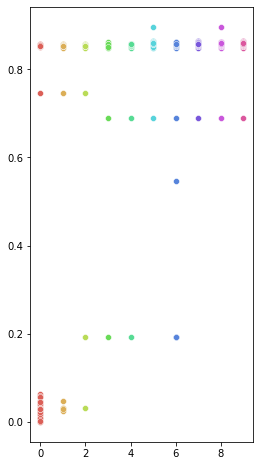

In [50]:
with open('logs_healing_5_points_thrown_rg_weightedv2_check.dat', 'rb') as f:
    _ = pickle.load(f)
    pp_logs = pickle.load(f)
    _ = pickle.load(f)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 8))
color_palette = sns.color_palette('hls', 10)
sns.scatterplot(x=[0] * len(pp_logs[0][25]), y=pp_logs[0][25], color=color_palette[0], ax=ax)
for i in range(len(pp_logs[1:]) - 1):
    y = pp_logs[i + 1][25]
    y = y[len(pp_logs[i][25]):]
    print(len(pp_logs[i+1][25]), len(pp_logs[i][25]))
    sns.scatterplot(x=[i] * len(y), y=y, color=color_palette[i], ax=ax)

plt.show()

### Check unified prediction weighted

In [105]:
with open(ROOT_PATH + 'code/logs_10thrown_rd_pointwise_weights_0.5_noise_fixed_points_wi.dat', 'rb') as f:
    up_logs = pickle.load(f)
    pp_logs = pickle.load(f)
    non_pred_logs = pickle.load(f)

In [131]:
predictor = TimeSeriesPredictor()
sep_indices = [0]
for i in range(len(pp_logs)):
    sep_indices.append(len(pp_logs[i][24]))
up, new_pp = predictor.unified_prediction_weighted(pp_logs[-1][24], \
    sep_indices=sep_indices, up_method='wi', weight_method='pointwise_weights', \
    return_pp_without_noise=True, factor=0.4)
print(up, len(new_pp))

0.22273339178535542 1599


In [120]:
with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
for c in cm:
    print(c[0])

[9 9 9]
[9 9 1]
[8 1 2]
[3 8 1]
[ 7 10  2]
[1 6 1]
[10  2  7]
[9 3 7]
[2 6 7]
[ 1 10  8]
[7 3 6]
[3 3 6]
[1 4 8]
[7 1 3]
[1 6 3]
[8 9 9]
[8 7 5]
[9 9 8]
[10  4  6]
[7 5 5]
[9 8 9]
[3 6 7]
[6 3 7]
[1 8 5]
[ 1 10 10]
[7 7 9]
[10  5  4]
[8 8 9]
[2 3 9]
[9 1 5]
[5 3 2]
[8 5 2]
[10  1  1]
[6 6 6]
[2 4 7]
[ 1  6 10]
[1 1 1]
[5 2 5]
[9 7 4]
[3 5 9]
[7 4 1]
[2 2 4]
[8 9 1]
[4 9 8]
[3 3 6]
[ 8 10  6]
[ 3 10  3]
[10  4  8]
[ 1  2 10]
[5 7 2]
[1 3 2]
[10  1  1]
[8 8 6]
[3 2 2]
[3 8 3]
[10 10  1]
[6 7 6]
[ 9  4 10]
[3 2 3]
[1 7 1]
[ 2 10 10]
[2 4 7]
[3 6 4]
[1 2 2]
[4 7 2]
[1 1 7]
[1 6 2]
[ 4 10  5]
[7 1 5]
[4 1 8]
[8 6 8]
[ 2  6 10]
[8 3 8]
[1 9 7]
[10  9  5]
[8 6 2]
[2 2 7]
[7 2 3]
[6 2 4]
[7 7 1]
[2 8 1]
[3 2 7]
[6 1 1]
[6 9 4]
[6 8 5]
[ 7 10  9]
[5 3 6]
[1 8 3]
[2 2 3]
[4 9 8]
[ 3  4 10]
[2 1 8]
[8 6 5]
[7 6 9]
[3 7 2]
[6 9 5]
[10  5 10]
[4 6 8]
[1 8 1]
[ 5  3 10]
[ 7 10  3]
[5 8 8]
[8 6 7]
[8 6 5]
[6 8 4]
[ 8  2 10]
[2 5 1]
[10 10  3]
[10 10  4]
[10  5  7]
[8 3 1]
[9 5 9]
[5 2 7]
[5 3 4]
[3 7

### Test

In [132]:
healing_params_list = [
    {
        'healing_up_method' : 'wi', 
        'weighted_up' : True,  
        # {'double_clustering', 'weighred_average', 'pointwise_weights'}
        'weight_method' : 'pointwise_weights', 
        'clear_noise' : True,
        'factor' : 0.4,
        'alg_type' : 's',
        'Y3' : None,
        'np_method' : 'rd',
        'mc_method' : 'wi',
        'beta' : 0.2,
        'fixed_points' : True,
        'healing_logs_filename' : 'logs_wi_wi_rd_pw_f0.4_noise_fixed_points.dat'
    },
    {
        'healing_up_method' : 'wi', 
        'weighted_up' : True,  
        # {'double_clustering', 'weighred_average', 'pointwise_weights'}
        'weight_method' : 'pointwise_weights', 
        'clear_noise' : True,
        'factor' : 0.4,
        'alg_type' : 's',
        'Y3' : None,
        'np_method' : 'rw',
        'mc_method' : 'wi',
        'beta' : 0.2,
        'fixed_points' : True,
        'healing_logs_filename' : 'logs_wi_wi_rw_pw_f0.4_noise_fixed_points.dat'
    },
    {
        'healing_up_method' : 'wi', 
        'weighted_up' : True,  
        # {'double_clustering', 'weighred_average', 'pointwise_weights'}
        'weight_method' : 'pointwise_weights', 
        'clear_noise' : True,
        'factor' : 0.4,
        'alg_type' : 's',
        'Y3' : None,
        'np_method' : 'rw',
        'mc_method' : 'wi',
        'beta' : 0.2,
        'fixed_points' : False,
        'healing_logs_filename' : 'logs_wi_wi_rw_pw_f0.4_noise.dat'
    },
    {
        'healing_up_method' : 'db', 
        'weighted_up' : True,  
        # {'double_clustering', 'weighred_average', 'pointwise_weights'}
        'weight_method' : 'pointwise_weights', 
        'clear_noise' : True,
        'factor' : 0.4,
        'alg_type' : 's',
        'Y3' : None,
        'np_method' : 'rd',
        'mc_method' : 'db',
        'beta' : 0.2,
        'fixed_points' : True,
        'healing_logs_filename' : 'logs_db_db_rd_pw_f0.4_noise_fixed_points.dat'
    }
]

In [135]:
def healing_task(healing_params):
    h = 100
    thrown = 5
    unified_predictions_test = np.array(Y2[:h], dtype=object)
    to_delete = [4, 44, 59, 90, 94] # np.random.choice(h, thrown, replace=False)
    unified_predictions_test[to_delete] = 'N'
    possible_predictions_test = [np.array([u] * 20) + \
        np.random.normal(0, 0.01, 20) if u != 'N' \
            else [] for u in unified_predictions_test]
    fixed_points_idx = np.delete(list(range(100)), to_delete)
    if not healing_params.get('fixed_points', True):
        fixed_points_idx = []
    Y_preceding = Y1[-31:]

    predictor = TimeSeriesPredictor()
    motifs_filename = 'motifs_' + healing_params.get('mc_method') + '_b' + \
        str(int(healing_params.get('beta') * 100)) + '.dat'
    with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
        cm = pickle.load(f)
    predictor.set_motifs(cm)
    npm = predictor.create_non_pred_model(**healing_params)
    predictor.set_non_pred_model(npm)
    up, pp = predictor.self_healing(Y_preceding, h, \
        return_n_iterations=False, \
        unified_predictions=unified_predictions_test, \
        possible_predictions=possible_predictions_test, \
        healing_logs_filepath=ROOT_PATH + 'results/five_points_exp/' +\
            healing_params.get('healing_logs_filename', 'logs.dat'),
        fixed_points_idx=fixed_points_idx,
        **healing_params)

In [136]:
Parallel(n_jobs=-2, backend='threading')(delayed(healing_task)(params) for params in healing_params_list)

KeyboardInterrupt: 

#### 

### Looking at 23 point, which patterns points come from?

In [197]:
healing_params_0 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'pointwise_weights'}
    'weight_method' : 'pointwise_weights', 
    'clear_noise' : True,
    'factor' : 0.5,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : True,
}

In [195]:
predictor = TimeSeriesPredictor()
with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
predictor.set_motifs(cm)
npm = RapidGrowthDBSCANNPM()
predictor.set_non_pred_model(npm)
Y_preceding = Y1[-31:]
to_delete = [3, 20, 24, 41, 44, 49, 51, 61, 65, 96] # np.random.choice(list(range(100)), 50, replace=False) #  # np.argwhere(up == 'N').reshape(1, -1)[0]   
unified_predictions_test = np.array(Y2[120:h+120], dtype=object)
unified_predictions_test[to_delete] = 'N'
possible_predictions_test = [np.array([unified_predictions_test] * 20) + \
    np.random.normal(0, 0.01, 20) if unified_predictions_test != 'N' \
        else [] for unified_predictions_test in unified_predictions_test]
# fixed_points_idx = np.argwhere(unified_predictions_test != 'N').reshape(1, -1)[0].tolist()  
fixed_points_idx = []

unified_preds, possible_predictions_list, n_iterations = \
    predictor.self_healing(Y_preceding, 100, return_n_iterations=True, \
        unified_predictions=unified_predictions_test, possible_predictions=possible_predictions_test, 
        healing_logs_filepath='check_logs_10_diffpiece_wi_db_rd_pw_f0.5_noise_jfrom1.dat',
        fixed_points_idx=fixed_points_idx,\
        **healing_params_0)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


### Trying self-healing on base algorithm

In [323]:
prediction_params_1 = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'rd', # {'fp', 'ls', 'rg', 'rd', 'rw'}
    'Y3' : None, # for large spread NPM
    'kappa' : 1, # for large spread NPM
}

healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'pointwise_weights', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'j_dist', 'j_dist_factor'}
    'weight_method' : 'j_dist_factor', 
    'clear_noise' : True,
    'factor' : 0.9,
    'alg_type' : 's',
    'Y3' : None,
    'np_method' : 'rd',
    'mc_method' : 'wi',
    'beta' : 0.2,
    'fixed_points' : True,
    'healing_motif_match_eps': 0.01
}

In [325]:
with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm)
Y_preceding = Y1[-31:]

Y_pred, possible_predictions_list = predictor.predict(Y_preceding, \
    100, **prediction_params_1)

In [330]:
possible_predictions_list[0]

array([0.87467648, 0.87087612, 0.88807825, ..., 0.89269559, 0.87970797,
       0.88366416])

In [326]:
unified_preds, possible_predictions_list, n_iterations = \
    predictor.self_healing(Y_preceding, 100, return_n_iterations=True, \
        unified_predictions=Y_pred, possible_predictions=possible_predictions_list, 
        healing_logs_filepath='logs_real_prediction.dat',
        fixed_points_idx=[],\
        **healing_params_1)

In [328]:
to_delete = np.argwhere(Y_pred == 'N')
unified_predictions_test = np.array(Y2[:h], dtype=object)
# to_delete = np.random.choice(h, thrown, replace=False) 
unified_predictions_test[to_delete] = 'N'
possible_predictions_test = [np.array([u] * 20) + \
    np.random.normal(0, 0.01, 20) if u != 'N' \
        else [] for u in unified_predictions_test]
fixed_points_idx = np.delete(list(range(h)), to_delete)
if not healing_params_1.get('fixed_points'):
    fixed_points_idx = []
Y_preceding = Y1[-31:]

with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm, 10, 3)
up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_real_prediction_tp_rd_wi_basealg_jdistfactor_true_initial_points.dat',
    fixed_points_idx=fixed_points_idx,
    **healing_params_1)

In [253]:
logregNPM = LogRegNPM(Y3)
rdNPM = RapidGrowthDBSCANNPM()

In [254]:
Y_test = Y2[:131]
with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
predictor = TimeSeriesPredictor(cm, None)
predictable_lr = []
predictable_rd = []
for i in range(32, len(Y_test)):
    Y_preceding = Y_test[:i - 1]
    pp, _ = predictor.predict_one_step(Y_preceding, [])
    predictable_lr.append(logregNPM.is_predictable(pp))
    predictable_rd.append(rdNPM.is_predictable(pp))

In [260]:
with open(ROOT_PATH + 'data/models/lr.dat', 'wb') as f:
    pickle.dump(logregNPM.logreg, f)

In [259]:
np.count_nonzero(np.array(predictable_lr) == np.array(predictable_rd)) / len(predictable_lr)

0.5858585858585859

### See where exactly wrong clusters come from

In [ ]:
# generating pieces of time series for each motif
clustered_motifs = []
k_max = 10
pattern_length = 3
beta=0.2

with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)

used_patterns = [x[0] for x in cm]
clustered_motifs_with_pieces = [] # (pattern, [motifs], [[indices]])

for pattern in used_patterns:
    eps = 0.01
    min_samples = 5
    motifs = []

    # make dataset for classification
    X_cl_idx = len(Y1) - 1 - np.cumsum(pattern[::-1])
    X_cl_idx = X_cl_idx[::-1]
    X_cl_idx = np.append(X_cl_idx, len(Y1) - 1)
    x = np.array([X_cl_idx - i for i in range(len(Y1) - np.sum(pattern))])

    X_cl = np.array([np.take(Y1, xi) for xi in x])
    
    X_cl = X_cl.astype(float)

    wishart = Wishart(min_samples, eps)
    cl_labels = wishart.fit(X_cl)
    cl_labels = cl_labels - 1

    n_clusters = len(np.unique(cl_labels))
    if np.isin(cl_labels, -1).any():
        n_clusters -= 1
    if n_clusters == 0:
        motifs = []
    else:
        pieces = [[(max(0, xi[0] - 30), min(len(Y1) - 1, xi[-1] + 30)) for xi in x[cl_labels  == i]] for i in range(n_clusters)]
        motifs = np.array([np.mean(X_cl[cl_labels  == i], axis=0) for i in range(n_clusters)])
    clustered_motifs_with_pieces.append((pattern, motifs, pieces))

with open(ROOT_PATH + 'results/predictions/04.15-21/clustered_motifs_with_pieces.dat', 'wb') as f:
    pickle.dump(clustered_motifs_with_pieces, f)

In [10]:
prediction_params_1 = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'cluster_size_threshold': 0, # Minimal percentage of points in largest cluster to call point predictable
    'one_cluster_rule': False, #Point is predictable only is there is one cluster (not including noise)
    'alg_type' : 'tp', # {'s', 'tp'}
    'n_trajectories' : 2,
    'np_method' : 'rd', # {'fp', 'ls', 'rg', 'rd', 'rw'}
    'Y3' : None, # for large spread NPM
    'kappa' : 1, # for large spread NPM
}

with open(ROOT_PATH + 'data/motifs/motifs_wi_b20.dat', 'rb') as f:
    cm = pickle.load(f)
npm = RapidGrowthDBSCANNPM()
predictor = TimeSeriesPredictor(cm, npm)
Y_preceding = Y1[-31:]

Y_pred, possible_predictions_list, trajectories = predictor.predict(Y_preceding, \
    100, **prediction_params_1)

In [11]:
from scipy.interpolate import interp1d

In [27]:
sns.set_style('whitegrid')

[Text(0.5, 1.0, 'Lorenz time series, trajectories'),
 Text(0, 0.5, 'value'),
 Text(0.5, 0, 'h')]

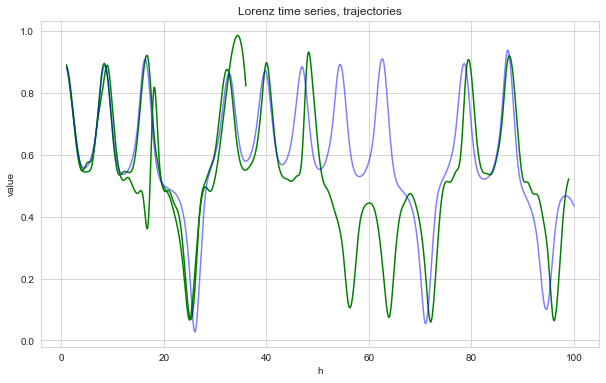

In [33]:
with open(ROOT_PATH + 'code/logs_real_prediction_tp_rd_wi_basealg_jdistfactor.dat', 'rb') as f:
    up_logs = pickle.load(f)
    pp_logs = pickle.load(f)

pp1 = trajectories[0]
pp2 = trajectories[1]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
h = len(up)
x = list(range(1, h + 1))

predictable = np.argwhere(pp1 != 'N').reshape(1, -1)[0]
y = np.take(pp1, predictable).astype(float)
x1 = np.take(x, predictable)
# sns.scatterplot(x=x1, y=y, color='green', ax=ax, linewidth=0, s=100)
interp = interp1d(x=x1, y=y, kind='cubic')
xi = np.linspace(1, predictable[-1], 1000)
yi = interp(xi)
sns.lineplot(x=xi, y=yi, color='green', ax=ax)

predictable = np.argwhere(pp2 != 'N').reshape(1, -1)[0]
y2 = np.take(pp2, predictable).astype(float)
x2 = np.take(x, predictable)
# sns.scatterplot(x=x2, y=y2, color='green', ax=ax, linewidth=0, s=100)
interp = interp1d(x=x2, y=y2, kind='cubic')
xi = np.linspace(1, predictable[-1], 1000)
yi = interp(xi)
sns.lineplot(x=xi, y=yi, color='green', ax=ax)

interp = interp1d(x=list(range(1, h+1)), y=Y2[:h], kind='cubic')
xi_true = np.linspace(1, 100, 1000)
yi_true = interp(xi_true)
sns.lineplot(x=xi_true, y=yi_true, ax=ax, color='blue', alpha=0.5)

ax.set(title='Lorenz time series, trajectories', ylabel='value', xlabel='h')

### Create new  non-pred algorithm

In [10]:
healing_params_1 = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'pointwise_weights', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'pointwise_weights', 
    'clear_noise' : False,
    'factor' : 0.9,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}

In [11]:
h = 100
to_delete = [4, 44, 59, 90, 94]
unified_predictions_test = np.array(Y2[:h], dtype=object)
# to_delete = np.random.choice(h, thrown, replace=False) 
unified_predictions_test[to_delete] = 'N'
possible_predictions_test = [np.array([u] * 20) + \
    np.random.normal(0, 0.01, 20) if u != 'N' \
        else [] for u in unified_predictions_test]
fixed_points_idx = np.delete(list(range(h)), to_delete)
if not healing_params_1.get('fixed_points'):
    fixed_points_idx = []
Y_preceding = Y1[-31:]

with open(ROOT_PATH + 'data/motifs/motifs_db_b20.dat', 'rb') as f:
    cm = pickle.load(f)

base_npm = RapidGrowthDBSCANNPM()
npm = WeirdPatternsNPM(Y1, eps0=0.07, base_non_pred_model=base_npm)

predictor = TimeSeriesPredictor(cm, npm, 10, 3)

up, pp = predictor.self_healing(Y_preceding, h, return_n_iterations=False, \
    unified_predictions=unified_predictions_test, \
    possible_predictions=possible_predictions_test, \
    healing_logs_filepath='logs_db_db_wfactor09_weirdpateps007_rd.dat',
    fixed_points_idx=fixed_points_idx,
    **healing_params_1)

### Healing on base alg

In [7]:
prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'cluster_size_threshold': 0, # Minimal percentage of points in largest cluster to call point predictable
    'one_cluster_rule': False, #Point is predictable only is there is one cluster (not including noise)
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp', # {'fp', 'ls', 'rg', 'rd', 'rw'}
}

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'pointwise_weights', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'pointwise_weights', 
    'clear_noise' : False,
    'factor' : 0.9,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}

In [9]:
h = 100

motifs_filename = 'motifs_db_b20.dat'
with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
    clustered_motifs = pickle.load(f)

base_npm = RapidGrowthDBSCANNPM()

predictor1 = TimeSeriesPredictor(clustered_motifs, base_npm, 10, 3)
        
Y_preceding = Y1[-31:]
unified_preds, possible_predictions_list = \
    predictor1.predict(Y_preceding, h, **prediction_params)

base_npm = LimitClusterSizeNPM(0.1, 20)
npm = WeirdPatternsNPM(Y1, eps0=0.07, base_non_pred_model=base_npm)
predictor1.set_non_pred_model(npm)

up, pp, n_iterations = predictor1.self_healing(Y_preceding, h, return_n_iterations=True, \
    unified_predictions=unified_preds, \
    possible_predictions=possible_predictions_list, \
    healing_logs_filepath='logs_ba_db_db_wfactor09_weirdpateps007_rd_lcs_01_20.dat',
    fixed_points_idx=[],
    **healing_params)

#### Experiment

In [110]:
def ba_healing_experiment(
    Y2, 
    motif_clustering_params, 
    prediction_params,
    healing_params,
    non_pred_model,
    logs_directory,
    n_test_passed=131):
    
    def exp_task_ba_healing(h, test_i):
        predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model, 10, 3)
        
        Y_preceding = Y2[:test_i + n_test_passed - h + 1]
        unified_preds, possible_predictions_list = \
            predictor1.predict(Y_preceding, h, **prediction_params)

        up, pp, n_iterations = predictor1.self_healing(Y_preceding, h, return_n_iterations=True, \
            unified_predictions=unified_preds, \
            possible_predictions=possible_predictions_list, \
            healing_logs_filepath=None,
            fixed_points_idx=[],
            **healing_params)

        filepath = logs_directory + 'logs_h_' + str(h) + '_test_i_' + str(test_i) + '.dat'
        with open(filepath, 'wb+') as f: 
            pickle.dump(up, f)
            pickle.dump(pp, f)
            pickle.dump(n_iterations, f)

    
    try:
        mc_method = motif_clustering_params.get('mc_method', 'db')
        beta_str = str(int(motif_clustering_params.get('beta', 0.2) * 100))
        motifs_filename = 'motifs_' + mc_method + '_b' + beta_str + '.dat'
        with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
            clustered_motifs = pickle.load(f)
    except FileNotFoundError:
        print('File with saved motifs not found!')
    
    hs = [5, 20, 50, 100]
    tests = [i * 10 for i in range(5)]
    args = list(product(hs, tests))
 
    Parallel(n_jobs=1)(delayed(exp_task_ba_healing)(h0, i0) for (h0, i0) in args)

In [111]:
motif_clustering_params = {
    'beta': 0.2,
    'mc_method': 'db'
}

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'cluster_size_threshold': 0, # Minimal percentage of points in largest cluster to call point predictable
    'one_cluster_rule': False, #Point is predictable only is there is one cluster (not including noise)
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'rd', # {'fp', 'ls', 'rg', 'rd', 'rw'}
}

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'pointwise_weights', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'pointwise_weights', 
    'clear_noise' : False,
    'factor' : 0.9,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01
}

In [112]:
# factor = 0.9, big leap between iterations
base_npm = LimitClusterSizeNPM(0.1, 20)
npm = BigLeapBtwIterationsNPM(base_non_pred_model=base_npm)

# os.mkdir(ROOT_PATH + 'results/f09_blbi_lcs01_20')
ba_healing_experiment(Y2, motif_clustering_params, prediction_params, \
    healing_params, npm, ROOT_PATH + 'results/f09_blbi_lcs01_20/')

pointwise_weights
[0.059189109203906486, 0.059189109203906486, 0.059189109203906486, 0.059189109203906486, 0.059189109203906486, 0.059189109203906486]
[0, 17]
1 0
1 0
1 0
1 0
1 0
1 0
1 0


IndexError: list index out of range

In [124]:
res = []
for test_i in [0, 10, 20, 30, 40]:
    exp_name = 'ba_lc01_20'
    motifs_filename = 'motifs_db_b20.dat'
    with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
        clustered_motifs = pickle.load(f)
    non_pred_model = LimitClusterSizeNPM(0.1, 20)
    predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model, 10, 3)
    Y_true0 = Y2[test_i + 131 - 100 + 1:test_i + 131 + 1]
    Y_preceding = Y2[:test_i + 131 - 100 + 1]
    up, pp = predictor1.predict(Y_preceding, 100, 'db', 's')

    predictable = np.argwhere(up != 'N')
    unified_preds_predicted = np.take(up, predictable).astype(float)
    if len(np.take(Y_true0, predictable)) > 0:
        rmse = np.sqrt(mean_squared_error(np.take(Y_true0, predictable), \
            unified_preds_predicted))
        mape = mean_absolute_percentage_error(np.take(Y_true0, predictable), \
            unified_preds_predicted)
    else:
        rmse = np.nan
        mape = np.nan
    npr = np.count_nonzero(up == 'N') / 100

    res.append({
        'exp_name' : exp_name,
        'test_i' : test_i,
        'rmse' : rmse,
        'mape' : mape,
        'npr' : npr
    })

In [125]:
res = pd.DataFrame(res)
res['rmse'] = list(map(lambda x : round(x, 2), res['rmse']))
res['mape'] = list(map(lambda x : round(x, 2), res['mape']))

In [126]:
res

,exp_name,test_i,rmse,mape,npr
0,ba_lc01_20,0,0.02,0.02,0.98
1,ba_lc01_20,10,0.15,0.36,0.16
2,ba_lc01_20,20,0.18,0.38,0.15
3,ba_lc01_20,30,0.20,0.45,0.16
4,ba_lc01_20,40,0.22,0.48,0.15


In [38]:
electricity = pd.read_excel('/Users/nastya/Downloads/MHLV_data-2015-2017.xlsx')
Y_e = electricity['Value']

In [39]:
n_train = 10_000
n_test = 1_000 + 300 # to get test set of 1000, 300 - про запас
n_passed = 0
n_valid = 2_000

Y_e = (np.array(Y_e) - min(Y_e)) / (max(Y_e) - min(Y_e))

Y1_e = np.array(Y_e[n_passed:n_passed + n_train]).reshape(-1)
Y2_e = np.array(Y_e[n_passed + n_train:n_passed + n_train + n_test]).reshape(-1)
Y3_e = np.array(Y_e[n_passed + n_train + n_test:n_passed + n_train + n_test + n_valid]).reshape(-1)

In [30]:
import seaborn as sns

<AxesSubplot:>

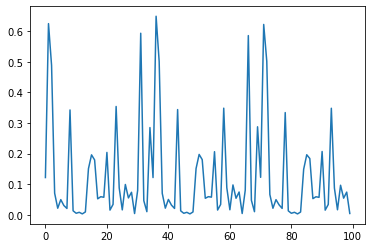

In [47]:
sns.lineplot(data=Y2_e[:100])

In [26]:
prdtr = TimeSeriesPredictor(None, None, 10, 3)
cm = prdtr.cluster_motifs(Y1_e, beta=0.2, mc_method='db')
with open(ROOT_PATH + 'data/motifs/motifs_electicity_db_b20.dat', 'wb')as f:
    pickle.dump(cm, f)

In [42]:
with open(ROOT_PATH + 'data/electricity_Y2.dat', 'wb') as f:
    pickle.dump(Y2_e, f)

### Gridsearch

In [35]:
def experiment_gridsearch(
    Y2, hs, h_dict, 
    # prediction_matrix, 
    iterations_range, 
    motif_clustering_params, 
    prediction_params,
    healing_params, 
    non_pred_model_prediction,
    non_pred_model_healing,
    logs_directory,
    run_self_healing=True,
    n_test_passed=131):
    
    def exp_task(h, test_i):
        predictor1 = TimeSeriesPredictor(clustered_motifs, non_pred_model_prediction)
        Y_preceding = Y2[:test_i + n_test_passed - h + 1]
        unified_preds, possible_predictions_list = \
            predictor1.predict(Y_preceding, h, **prediction_params)
        predictor1.set_non_pred_model(non_pred_model_healing)
        if run_self_healing:
            up, pp = predictor1.self_healing(\
                Y_preceding, h, \
                return_n_iterations=False, \
                unified_predictions=unified_preds, \
                possible_predictions=possible_predictions_list, \
                healing_logs_filepath=None,
                fixed_points_idx=[],
                **healing_params)
            with open(logs_directory + 'log/log_' + str(h) + '_' + str(test_i) + '.dat', 'wb') as f:
                pickle.dump(up[-1], f)
        else:
            with open(logs_directory + 'log/log_' + str(h) + '_' + str(test_i) + '.dat', 'wb') as f:
                pickle.dump(unified_preds[-1], f)


    # start experiment_no_pm    
    try:
        mc_method = motif_clustering_params.get('mc_method', 'db')
        beta_str = str(int(motif_clustering_params.get('beta', 0.2) * 100))
        motifs_filename = 'motifs_' + mc_method + '_b' + beta_str + '.dat'
        with open(ROOT_PATH + 'data/motifs/' + motifs_filename, 'rb') as f:
            clustered_motifs = pickle.load(f)
    except FileNotFoundError:
        print('File with saved motifs not found!')
        return
    
    args = list(product(hs, list(range(iterations_range[0], iterations_range[1]))))
    if not os.path.exists(logs_directory + 'log/'):
        os.mkdir(logs_directory + 'log/')

    # ! change to -1
    Parallel(n_jobs=1, backend='threading')(delayed(exp_task)(h0, i0) for (h0, i0) in args)

    prediction_matrix = np.empty((len(hs), iterations_range[1] - iterations_range[0]), \
        dtype=object)
    for h0, i0 in args:
        with open(logs_directory + 'log/log_' + str(h0) + '_' + str(i0) + '.dat', 'rb') as f:
            up = pickle.load(f)
            prediction_matrix[h_dict[h0], i0] = up
    with open(logs_directory + 'pm.dat', 'wb') as f:
        pickle.dump(hs, f)
        pickle.dump(iterations_range, f)
        pickle.dump(prediction_matrix, f)

    for file_name in os.listdir(logs_directory + 'log/'):
        # construct full file path
        file = logs_directory + 'log/' + file_name
        if os.path.isfile(file):
            os.remove(file)
    os.rmdir(logs_directory + 'log/')

In [36]:
motif_clustering_params = {
    'beta': 0.2,
    'mc_method': 'db'
}

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's' # {'s', 'tp'}
}

healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 0.7,
    'alg_type' : 's',
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01,
    'eps_stop' : 0.05,
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
}

non_pred_model_prediction = LimitClusterSizeNPM(0.5, 1)
base_model = LimitClusterSizeNPM(0.5, 5)
non_pred_model_healing = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=base_model)


In [37]:
experiment_gridsearch(Y2, [5], {5:0}, (0, 20), motif_clustering_params, \
    prediction_params, healing_params, non_pred_model_prediction, \
    non_pred_model_healing, ROOT_PATH + 'results/predictions/14.06/test/')

KeyboardInterrupt: 

In [38]:
def gridsearch(Y_test, test_size, hs, logs_directory,\
    motif_clustering_params, prediction_params, healing_params,
    non_pred_model_prediction, non_pred_model_healing,
    params_grid):

    columns = ['\n'.join([str(key) for key in list(params_grid.keys())])]
    for h in hs:
        columns.append('h=' + str(h) + ', RMSE')
        columns.append('h=' + str(h) + ', np')

    result_table = pd.DataFrame(columns=columns)
    args = product(*params_grid.values())
    h_dict = dict(zip(hs, list(range(len(hs)))))
    run_self_healing = True
    for arg in args:
        for i in range(len(params_grid.keys())):
            key = list(params_grid.keys())[i]
            if key == 'non_pred_model_prediction':
                non_pred_model_prediction = arg[i]
            if key == 'non_pred_model_healing':
                non_pred_model_healing = arg[i]
            if key == 'run_self_healing':
                run_self_healing = arg[i]
            if key in motif_clustering_params.keys():
                motif_clustering_params[key] = arg[i]
            if key in prediction_params.keys():
                prediction_params[key] = arg[i]
            if key in healing_params.keys():
                healing_params[key] = arg[i]
        
        experiment_gridsearch(Y_test, hs, h_dict, (0, test_size), \
            motif_clustering_params=motif_clustering_params, \
            prediction_params=prediction_params, \
            healing_params=healing_params, \
            non_pred_model_prediction=non_pred_model_prediction,
            non_pred_model_healing=non_pred_model_healing, 
            logs_directory=logs_directory,
            run_self_healing=run_self_healing,
            n_test_passed=131)
        
        with open(logs_directory + 'pm.dat', 'rb') as f:
            _ = pickle.load(f)
            _ = pickle.load(f)
            pm = pickle.load(f)
        
        arg_str = '\n'.join([str(a) for a in arg])
        Y_true = Y_test[131:131+test_size]
        row = [arg_str]
        for j in range(len(hs)):
            Y_pred = pm[j]
            predictable = np.argwhere(Y_pred != 'N').reshape(1, -1)[0]
            if len(predictable) > 0:
                row.append(mean_squared_error(np.take(Y_true, predictable), \
                    np.take(Y_pred, predictable), squared=False))
            else:
                row.append(np.nan)

            row.append((test_size - len(predictable)) / test_size)
        result_table.loc[len(result_table)] = row
        result_table.to_csv(logs_directory + 'gridsearch_result_table.csv')

    return result_table

In [31]:
bm1 = LimitClusterSizeNPM(0.5, 5)
npm1 = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=bm1)

bm2 = LimitClusterSizeNPM(0.7, 5)
npm2 = WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=bm2)

params_grid = {
    'non_pred_model_healing' : [npm1, npm2],
    'factor' : [0.5, 1.5]
}

res = gridsearch(
    Y_test=Y2, 
    test_size=10, 
    hs=[5], 
    logs_directory=ROOT_PATH + 'results/predictions/14.06/test/',
    motif_clustering_params=motif_clustering_params,
    prediction_params=prediction_params,
    healing_params=healing_params,
    non_pred_model_prediction=non_pred_model_prediction, 
    non_pred_model_healing=non_pred_model_healing,
    params_grid=params_grid
    )